In [2]:
from imgaug import augmenters as iaugs
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential
from keras.layers import *

Using TensorFlow backend.


In [4]:
seq = iaugs.Sequential([
    
    iaugs.Crop(px=(0, 10)),                                    # cropping images from each side by 0 to 10 pixels randomly
    iaugs.Fliplr(0.4),                                         # horizontally flipping 40% of the images
    iaugs.GaussianBlur(sigma=(0, 1.0)),                        # Gaussian blur images with a sigma of 0 to 1.0
                                                                
    iaugs.Affine(                                                  # Affine transformations 
        scale={"x": (1.0, 1.2), "y": (1.0, 1.2)},
        translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
        rotate=(-15, 15)
        )
    ])

In [10]:
model = Sequential()

model.add(Conv2D(30,(3,3),activation='relu',input_shape=(100,100,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(60,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(70,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(70,activation='relu'))
model.add(Dense(5,activation='softmax'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 98, 98, 30)        840       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 60)        16260     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 60)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 70)        37870     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 70)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 70)               

In [11]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
## Data Preparation using Keras
from keras.preprocessing.image import ImageDataGenerator

#Specify what operations to apply on each image when it is loaded
train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory('Train',batch_size=40,target_size=(100,100),
                                          class_mode='categorical',shuffle=True)


val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory('Val',class_mode='categorical',batch_size=16,
                                                target_size=(100,100),shuffle=True)

Found 1564 images belonging to 5 classes.
Found 273 images belonging to 5 classes.


In [13]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

modelcheckpoint = ModelCheckpoint("./best_model.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=13, verbose=1, restore_best_weights=True)
CallBks= [modelcheckpoint, early_stop]

hist = model.fit_generator(train_generator,epochs=100,steps_per_epoch= 33,shuffle=True,
                                    validation_data=val_generator,validation_steps=10,callbacks=CallBks)

Epoch 1/100
33/33 [==============================] - 13s 383ms/step - loss: 1.6043 - accuracy: 0.2477 - val_loss: 1.5568 - val_accuracy: 0.1875

Epoch 00001: val_accuracy improved from -inf to 0.18750, saving model to ./best_model.h5
Epoch 2/100
33/33 [==============================] - 11s 330ms/step - loss: 1.5689 - accuracy: 0.2928 - val_loss: 1.5790 - val_accuracy: 0.2690

Epoch 00002: val_accuracy improved from 0.18750 to 0.26897, saving model to ./best_model.h5
Epoch 3/100
33/33 [==============================] - 8s 256ms/step - loss: 1.2983 - accuracy: 0.3956 - val_loss: 1.4498 - val_accuracy: 0.3000

Epoch 00003: val_accuracy improved from 0.26897 to 0.30000, saving model to ./best_model.h5
Epoch 4/100
33/33 [==============================] - 9s 262ms/step - loss: 1.0940 - accuracy: 0.4492 - val_loss: 1.7991 - val_accuracy: 0.2690

Epoch 00004: val_accuracy did not improve from 0.30000
Epoch 5/100
33/33 [==============================] - 9s 273ms/step - loss: 1.0836 - accuracy: 

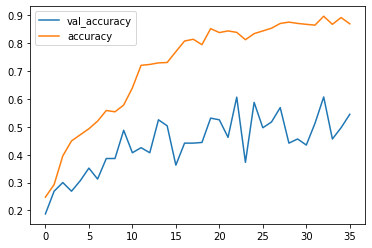

In [15]:
res = hist.history

plt.plot(res['val_accuracy'], label = "val_accuracy")
plt.plot(res['accuracy'], label = "accuracy")
plt.legend()
plt.show()

In [16]:
NameToIndices = train_generator.class_indices
IndicesToName = dict((NameToIndices[i],i) for i in NameToIndices)

In [18]:
IndicesToName

{0: 'Fist', 1: 'OK', 2: 'One', 3: 'Perfect', 4: 'Two'}

In [19]:
datafolder = "./Test/"

import os
import cv2

images = os.listdir(datafolder)
len(images)

58

In [20]:
X_test = np.zeros((58,100,100,3))
labels = np.zeros((58,))

for i in range(len(images)) :
    
    img = cv2.imread(datafolder+images[i])
    newImg = cv2.resize(img,(100,100))
    X_test[i] = newImg
    
labels[:8] = 2
labels[8:24] = 4
labels[24:44] = 0
labels[44:] = 1

In [21]:
batch = X_test[10]
batch = np.reshape(batch,(1,*batch.shape))

y_pred = model.predict(batch)

In [22]:
y_pred

array([[0., 0., 1., 0., 0.]], dtype=float32)